# Классификация данных Speedtest
В рамках данного ноутбука поработаем непосредственно с обработанными данными.

## Подготовка к работе
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import pandas as pd
import tensorflow as tf

import seaborn as sns

2023-05-12 09:01:47.663147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:01:48.331416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 0  # to reproduce building
BATCH_SIZE = 4

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = 'data/light'
LOGS_PATH = 'logs/light'
VISUAL_PATH = 'visual/model/light'
MODEL_PATH = 'model/light'

In [3]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

### Подготовка датасета
Загрузим датасет, отсортируем значения по годам и уровню ВВП и уберём лишние признаки

In [4]:
df = (
    pd.read_csv(f'{DATA_PATH}/fixed/fixed_light.csv')
    .sort_values(by=['year', 'income'])
    .drop(columns=['iso_a3', 'label', 'income'])
)

df.head()

,year,group,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
724,2019,Low income,2488.000,746.250,147.000000,433441,102768
616,2019,Low income,1488.375,697.000,688.500000,889,308
752,2019,Low income,7779.750,4636.625,26.500000,20461,7358
44,2019,Low income,7248.500,7556.250,27.000000,2272,727
112,2019,Low income,1071.500,1191.875,401.583333,159,85


Закодируем исследуемую категорию

In [5]:
values, uniques = pd.factorize(df['group'])
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(uniques)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Разделим датасет на обучающий набор - 80%, и на тестовый - 20%

In [6]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(len(train_df), 'training examples')
print(len(test_df), 'testing examples')

605 training examples
151 testing examples


Дропнем из признаков зависимую переменную

In [7]:
train_features = train_df.copy()
train_target = tf.keras.utils.to_categorical(train_features.pop('group'))

In [8]:
test_features = test_df.copy()
test_target = tf.keras.utils.to_categorical(test_features.pop('group'))

Из ноутбука с визуализацией было выяснено, что признаки выраженное левостороннее распределение.
Создадим слой для их нормализации и подгоним его состояние предварительной обработки к признакам

In [9]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE // 2)

2023-05-12 09:01:49.118665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 09:01:49.154778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 09:01:49.154838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 09:01:49.157695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-12 09:01:49.158030: I tensorflow/compile

## Регрессия с глубокой нейронной сетью (DNN)
Регрессия с использованием DNN и нескольких входных данных

### Настройка модели
Зададим параметры обучения модели

Модель тем качественнее обучается, чем больше у неё есть время.
Оптимизируем обучение, замедляя его с каждой эпохой

In [10]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=1000,
    decay_rate=1,
)

В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [11]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 50):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            'accuracy'
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # amount model trains
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{model.name}'),
        ],
    )

    return history.history

### Обучение моделей
Создадим переменную, в которой будут сохранятся логи обучения моделей

In [12]:
size_histories = {}

#### Tiny
Начнём с самой маленькой модели, состоящей из двух обучающих слоёв

In [13]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(train_target.shape[1]),
    ],
    name='tiny'
)

In [14]:
size_histories['tiny'] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                112       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 193
Trainable params: 180
Non-trainable params: 13
_________________________________________________________________
Epoch 1/50


2023-05-12 09:01:52.114170: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x34970a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-12 09:01:52.114212: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-12 09:01:52.118467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-12 09:01:53.284740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-12 09:01:53.403998: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 - 3s - loss: 5.8485 - accuracy: 0.0000e+00 - val_loss: 6.9904 - val_accuracy: 0.0000e+00 - 3s/epoch - 51ms/step
Epoch 2/50
61/61 - 0s - loss: 6.9455 - accuracy: 0.0000e+00 - val_loss: 7.8612 - val_accuracy: 0.0000e+00 - 307ms/epoch - 5ms/step
Epoch 3/50
61/61 - 0s - loss: 7.8535 - accuracy: 0.0000e+00 - val_loss: 9.4794 - val_accuracy: 0.0000e+00 - 266ms/epoch - 4ms/step
Epoch 4/50
61/61 - 0s - loss: 8.3331 - accuracy: 0.0000e+00 - val_loss: 8.9815 - val_accuracy: 0.0000e+00 - 279ms/epoch - 5ms/step
Epoch 5/50
61/61 - 0s - loss: 8.4007 - accuracy: 0.0000e+00 - val_loss: 7.3111 - val_accuracy: 0.0000e+00 - 283ms/epoch - 5ms/step
Epoch 6/50
61/61 - 0s - loss: 7.7306 - accuracy: 0.0000e+00 - val_loss: 6.0501 - val_accuracy: 0.0000e+00 - 270ms/epoch - 4ms/step
Epoch 7/50
61/61 - 0s - loss: 7.0291 - accuracy: 0.0000e+00 - val_loss: 5.0296 - val_accuracy: 0.0000e+00 - 270ms/epoch - 4ms/step
Epoch 8/50
61/61 - 0s - loss: 6.7947 - accuracy: 0.0000e+00 - val_loss: 5.5304 - val_accuracy: 0

Визуализируем ход обучения

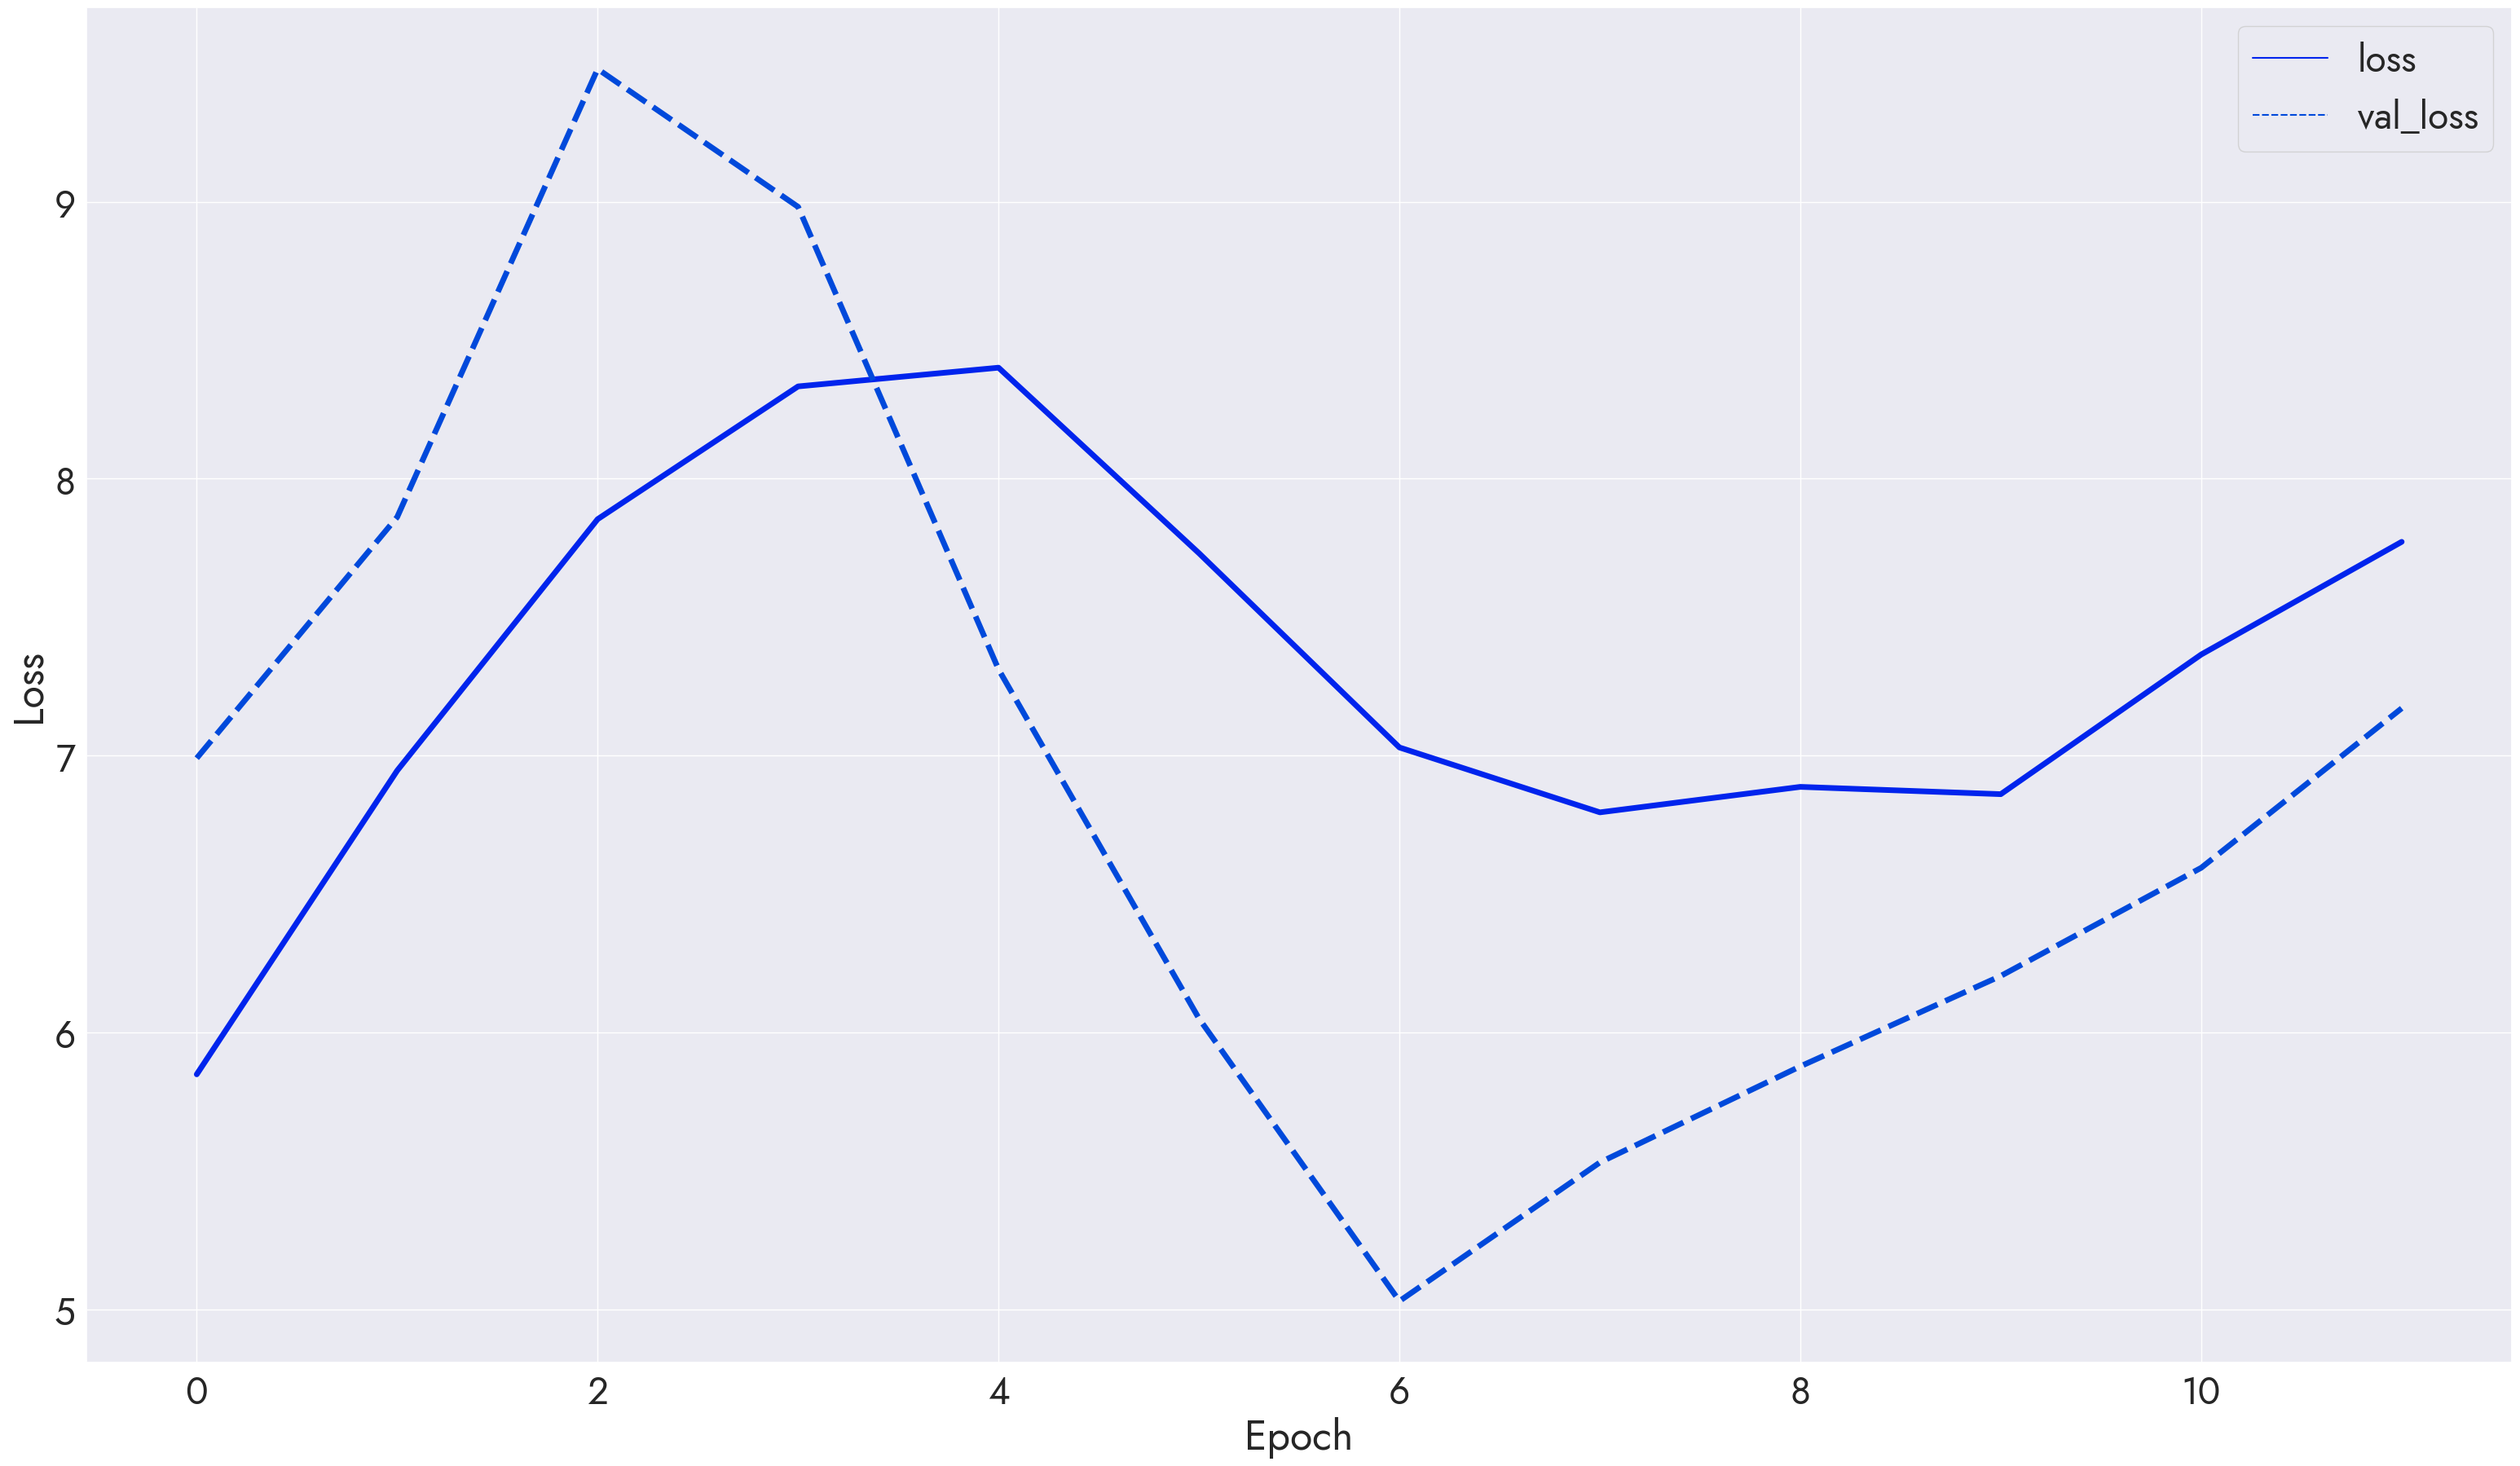

In [15]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['tiny'])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('Epoch')
tiny_plot_history.set_ylabel('Loss');

In [16]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_tiny_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [17]:
tiny_evaluation = tiny_model.evaluate(train_features, train_target, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

19/19 - 0s - loss: 7.8257 - accuracy: 0.0000e+00 - 64ms/epoch - 3ms/step
Accuracy: 0.0


In [18]:
tiny_evaluation = tiny_model.evaluate(test_features, test_target, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

5/5 - 0s - loss: 7.6104 - accuracy: 0.0000e+00 - 35ms/epoch - 7ms/step
Accuracy: 0.0


Сохраним модель для возможности её использования в будущем

In [19]:
tiny_model.save(f'{MODEL_PATH}/fixed_tiny')

INFO:tensorflow:Assets written to: model/light/fixed_tiny/assets


#### Small

In [20]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(train_target.shape[1]),
    ],
    name='small'
)

In [21]:
size_histories['small'] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                112       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 465
Trainable params: 452
Non-trainable params: 13
______________________________________________________________

Визуализируем ход обучения

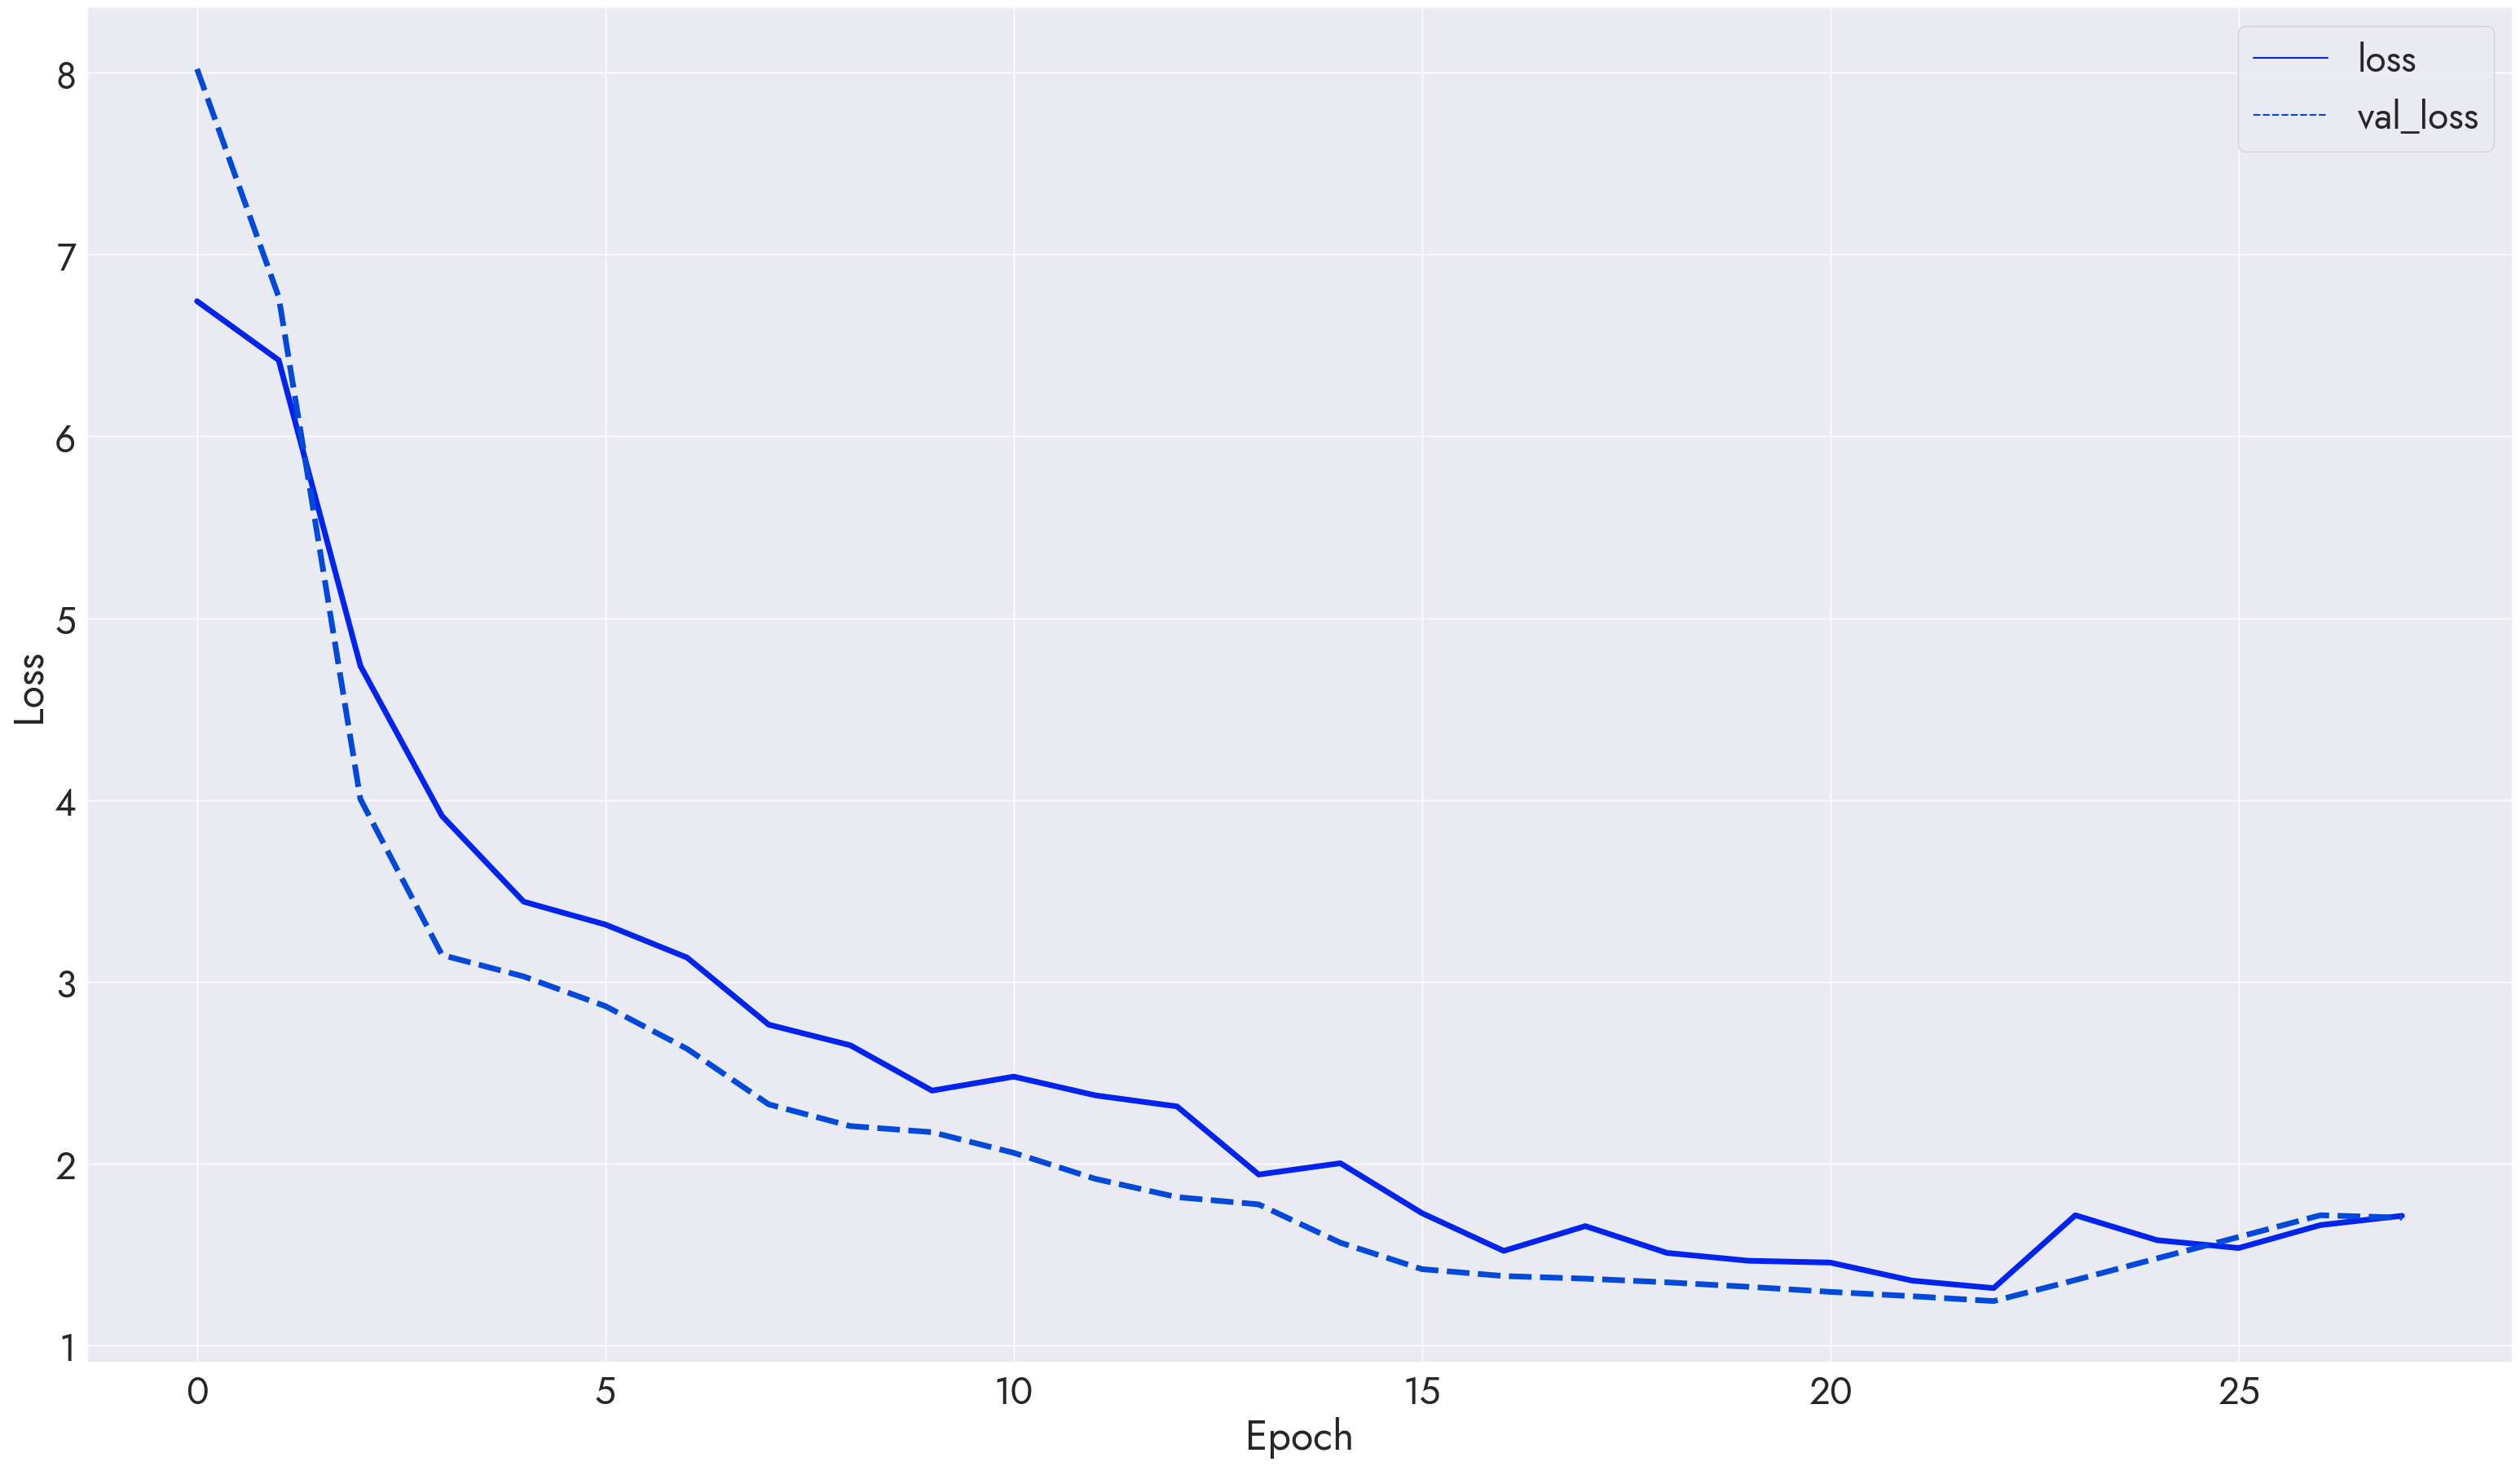

In [22]:
small_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['small'])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('Epoch')
small_plot_history.set_ylabel('Loss');

In [23]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_small_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [24]:
small_evaluation = small_model.evaluate(train_features, train_target, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

19/19 - 0s - loss: 1.6859 - accuracy: 0.0000e+00 - 74ms/epoch - 4ms/step
Accuracy: 0.0


In [25]:
small_evaluation = small_model.evaluate(test_features, test_target, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

5/5 - 0s - loss: 1.8479 - accuracy: 0.0000e+00 - 36ms/epoch - 7ms/step
Accuracy: 0.0


Сохраним модель для возможности её использования в будущем

In [26]:
small_model.save(f'{MODEL_PATH}/fixed_small')

2023-05-12 09:02:10.447603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-05-12 09:02:10.579318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed_small/assets


#### Medium

In [27]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dense(train_target.shape[1]),
    ],
    name='medium'
)

In [28]:
size_histories['medium'] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                448       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 4,881
Trainable params: 4,868
Non-trainable params: 13
_________________________________________________________

Визуализируем ход обучения

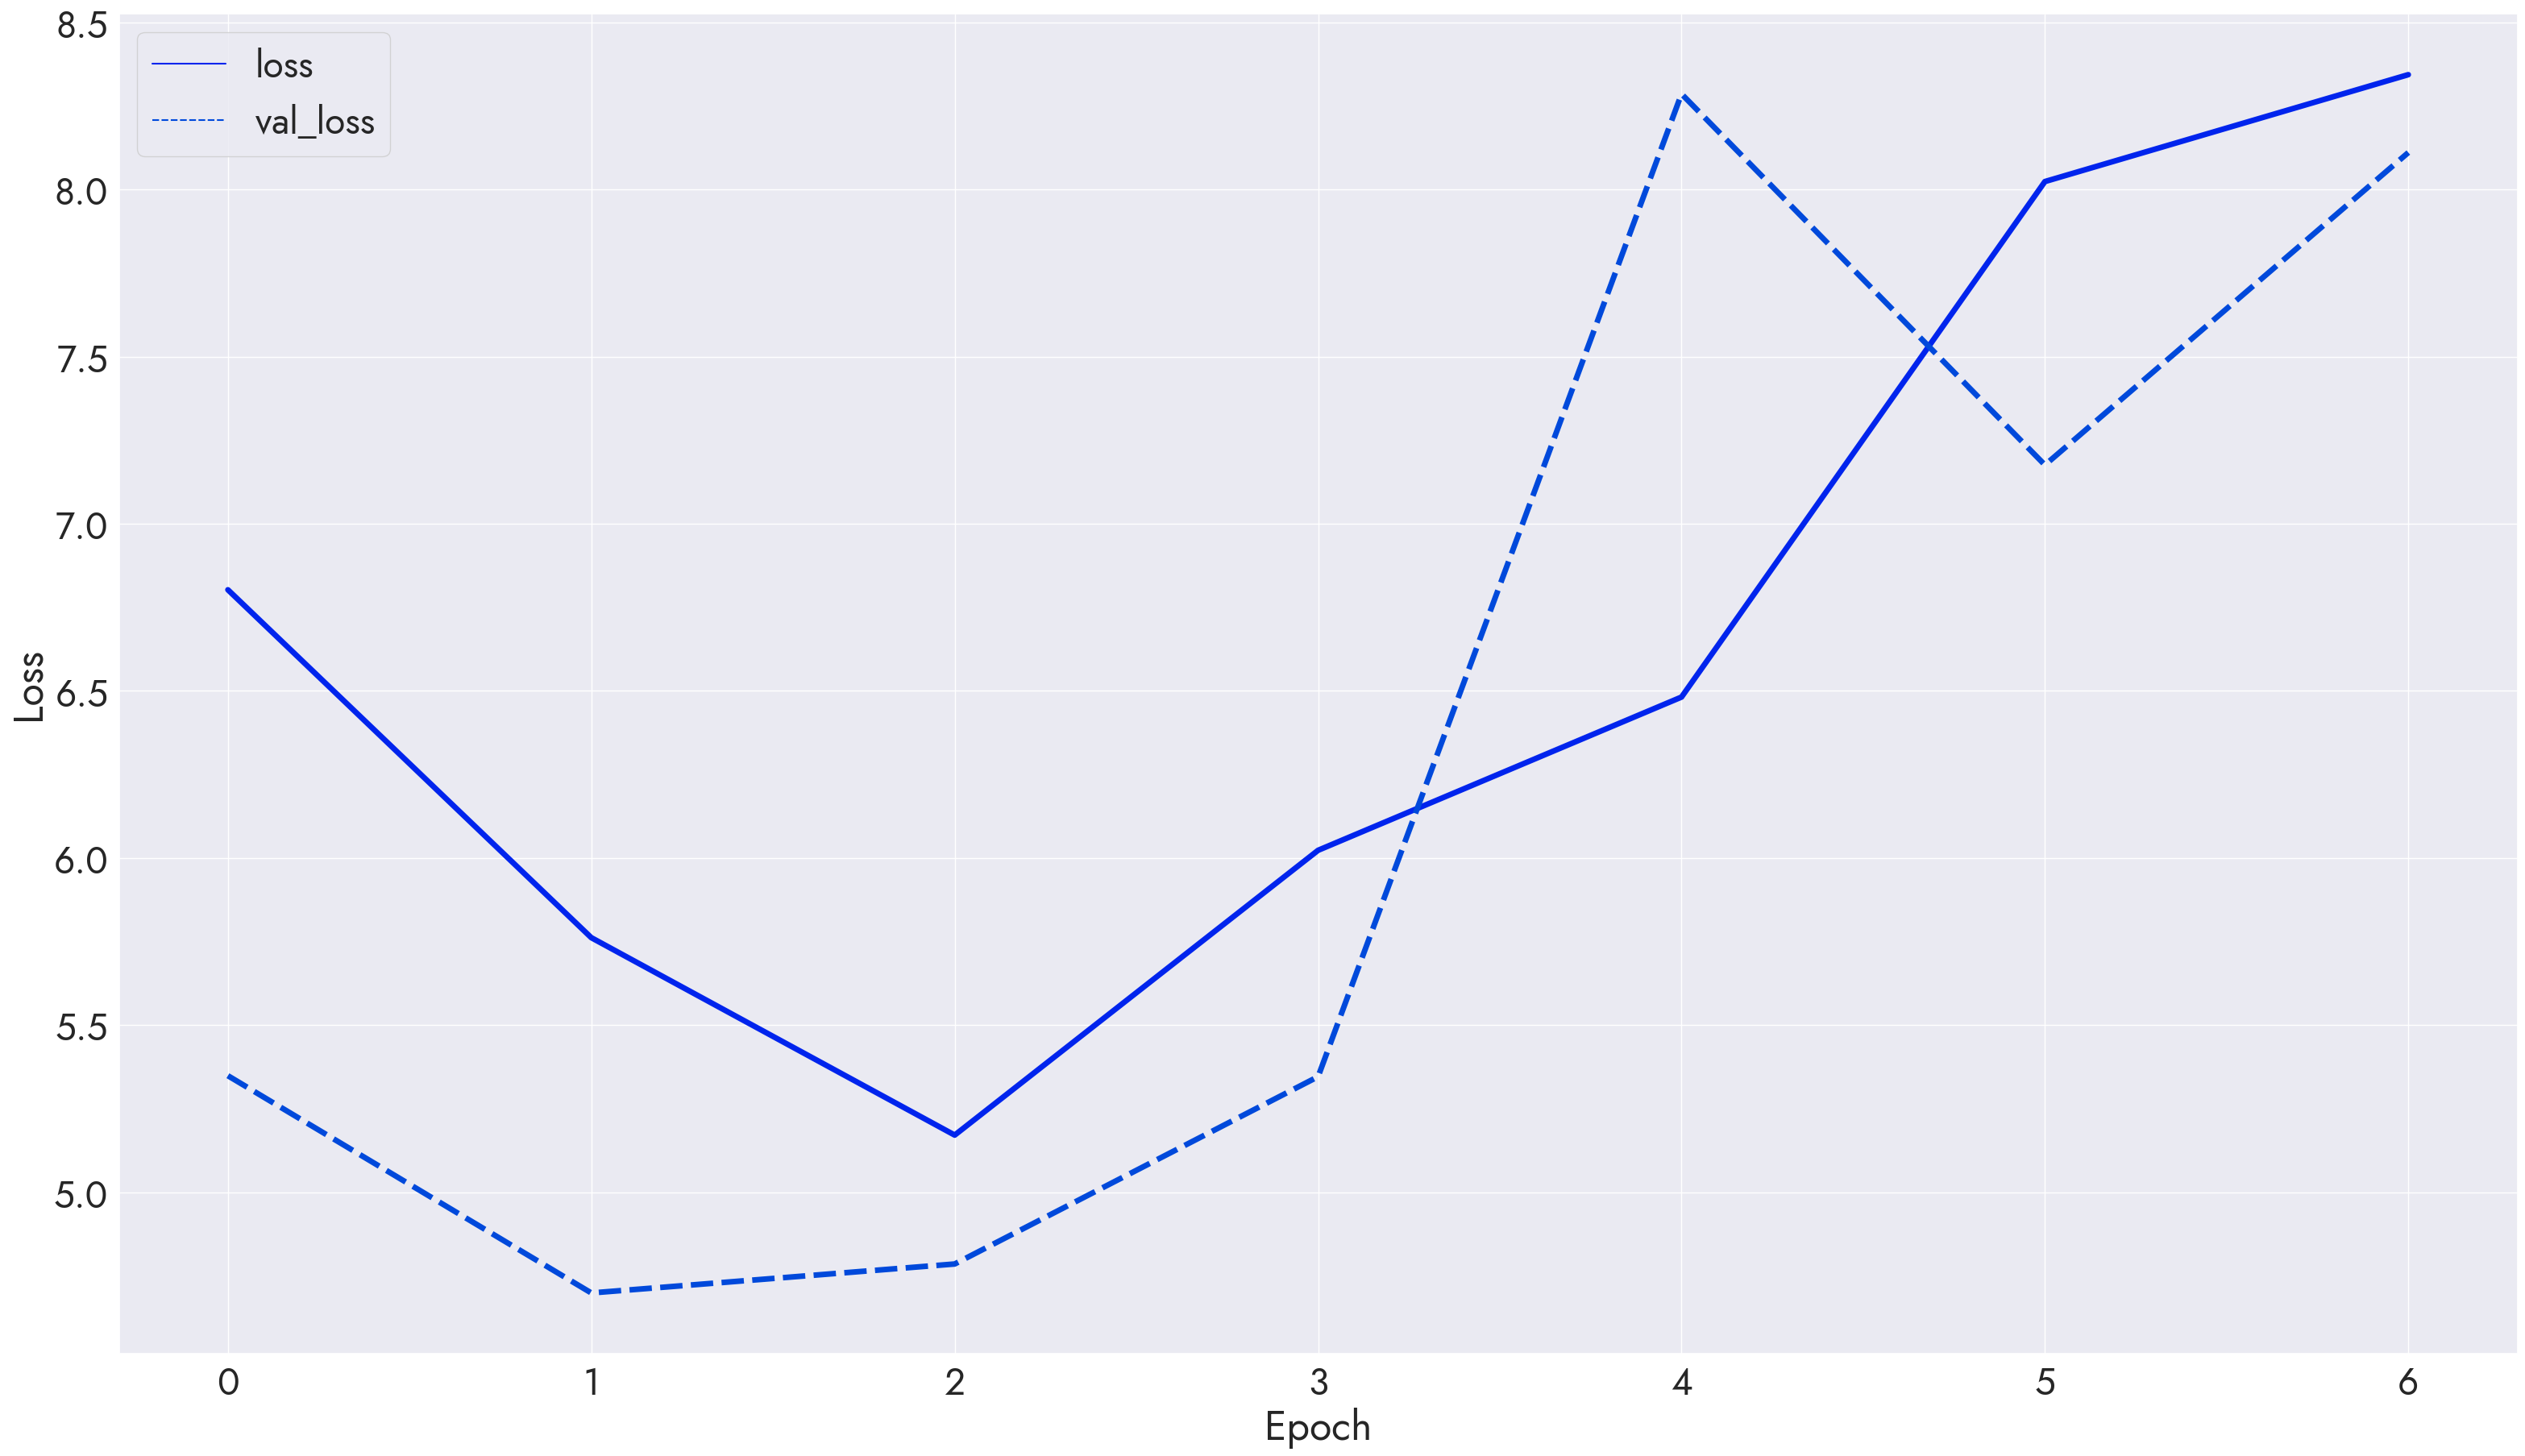

In [29]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['medium'])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('Epoch')
medium_plot_history.set_ylabel('Loss');

In [30]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_medium_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [31]:
medium_evaluation = medium_model.evaluate(train_features, train_target, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

19/19 - 0s - loss: 8.7679 - accuracy: 0.0000e+00 - 76ms/epoch - 4ms/step
Accuracy: 0.0


In [32]:
medium_evaluation = medium_model.evaluate(test_features, test_target, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

5/5 - 0s - loss: 9.2116 - accuracy: 0.0000e+00 - 38ms/epoch - 8ms/step
Accuracy: 0.0


Сохраним модель для возможности её использования в будущем

In [33]:
medium_model.save(f'{MODEL_PATH}/fixed_medium')

2023-05-12 09:02:16.263137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-12 09:02:16.423001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed_medium/assets


#### Large

In [34]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
        tf.keras.layers.Dense(train_target.shape[1]),
    ],
    name='large'
)

In [35]:
size_histories['large'] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 512)               3584      
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                             

Визуализируем ход обучения

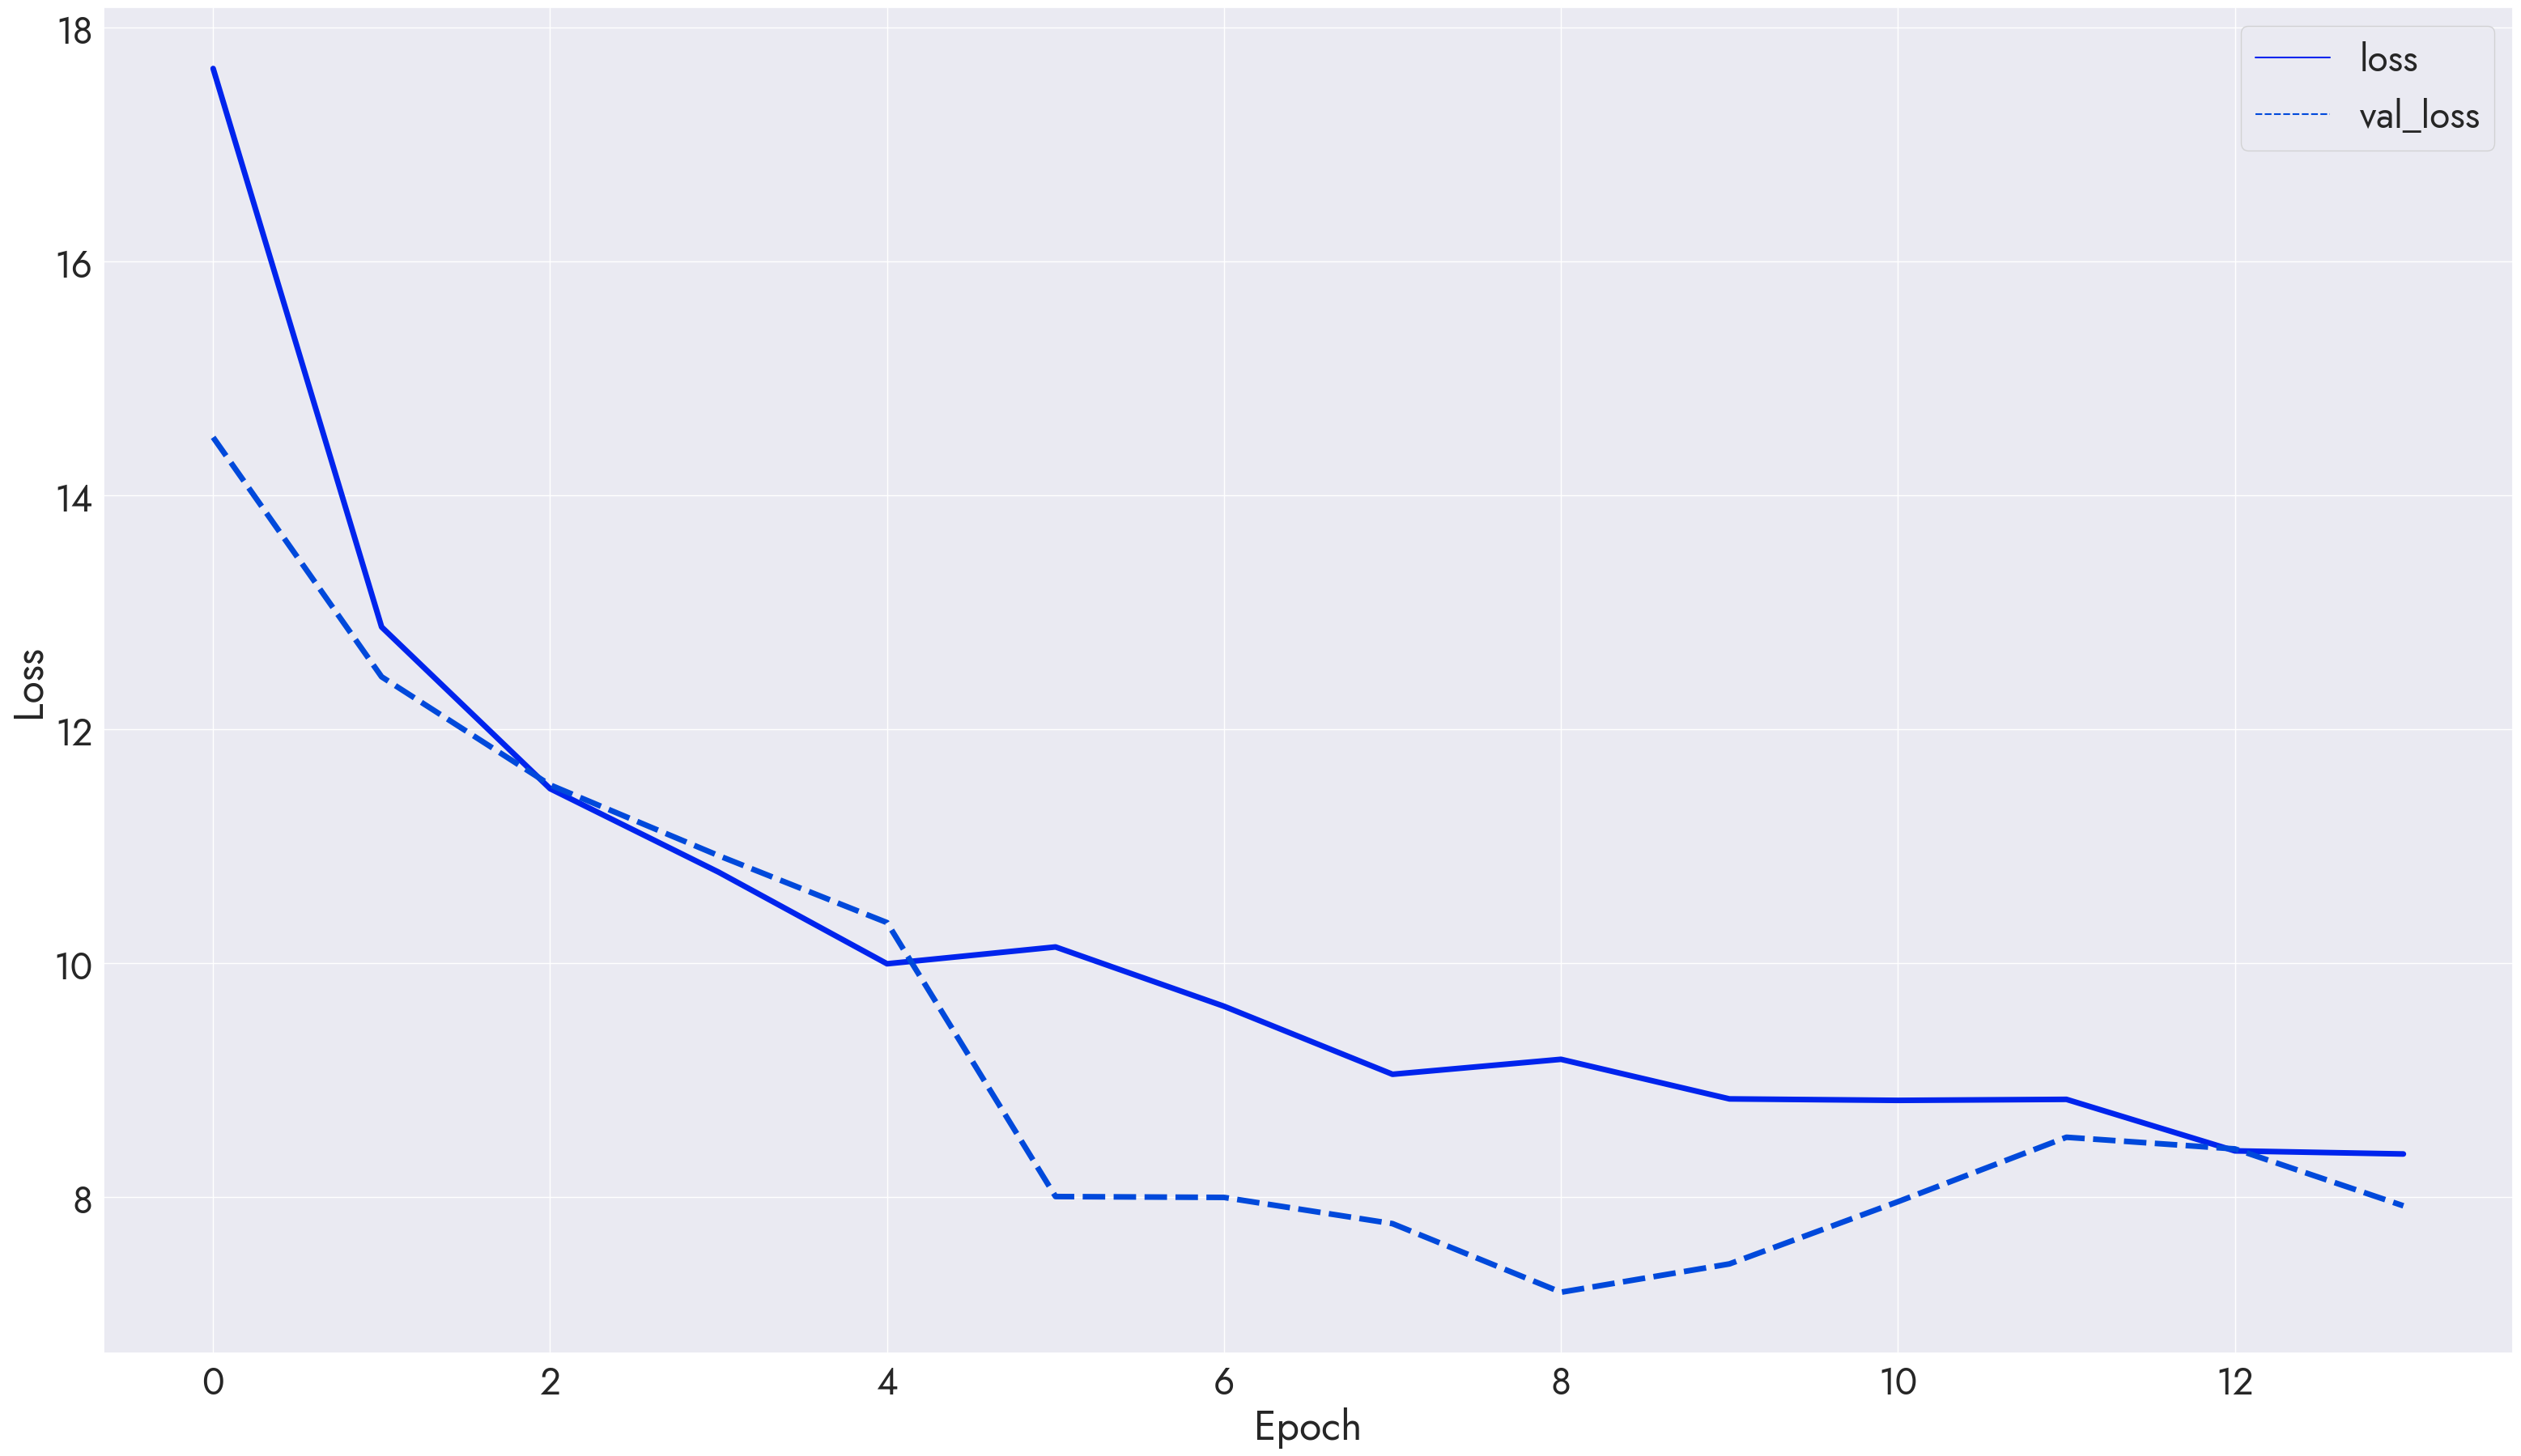

In [36]:
large_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['large'])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('Epoch')
large_plot_history.set_ylabel('Loss');

In [37]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_large_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [38]:
large_evaluation = large_model.evaluate(train_features, train_target, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

19/19 - 0s - loss: 8.0081 - accuracy: 0.0000e+00 - 69ms/epoch - 4ms/step
Accuracy: 0.0


In [39]:
large_evaluation = large_model.evaluate(test_features, test_target, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

5/5 - 0s - loss: 7.0328 - accuracy: 0.0000e+00 - 37ms/epoch - 7ms/step
Accuracy: 0.0


Сохраним модель для возможности её использования в будущем

In [40]:
large_model.save(f'{MODEL_PATH}/fixed_large')

2023-05-12 09:02:26.232561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-12 09:02:26.249940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-12 09:02:26.467753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-12 09:02

INFO:tensorflow:Assets written to: model/light/fixed_large/assets


#### Итоговая модель

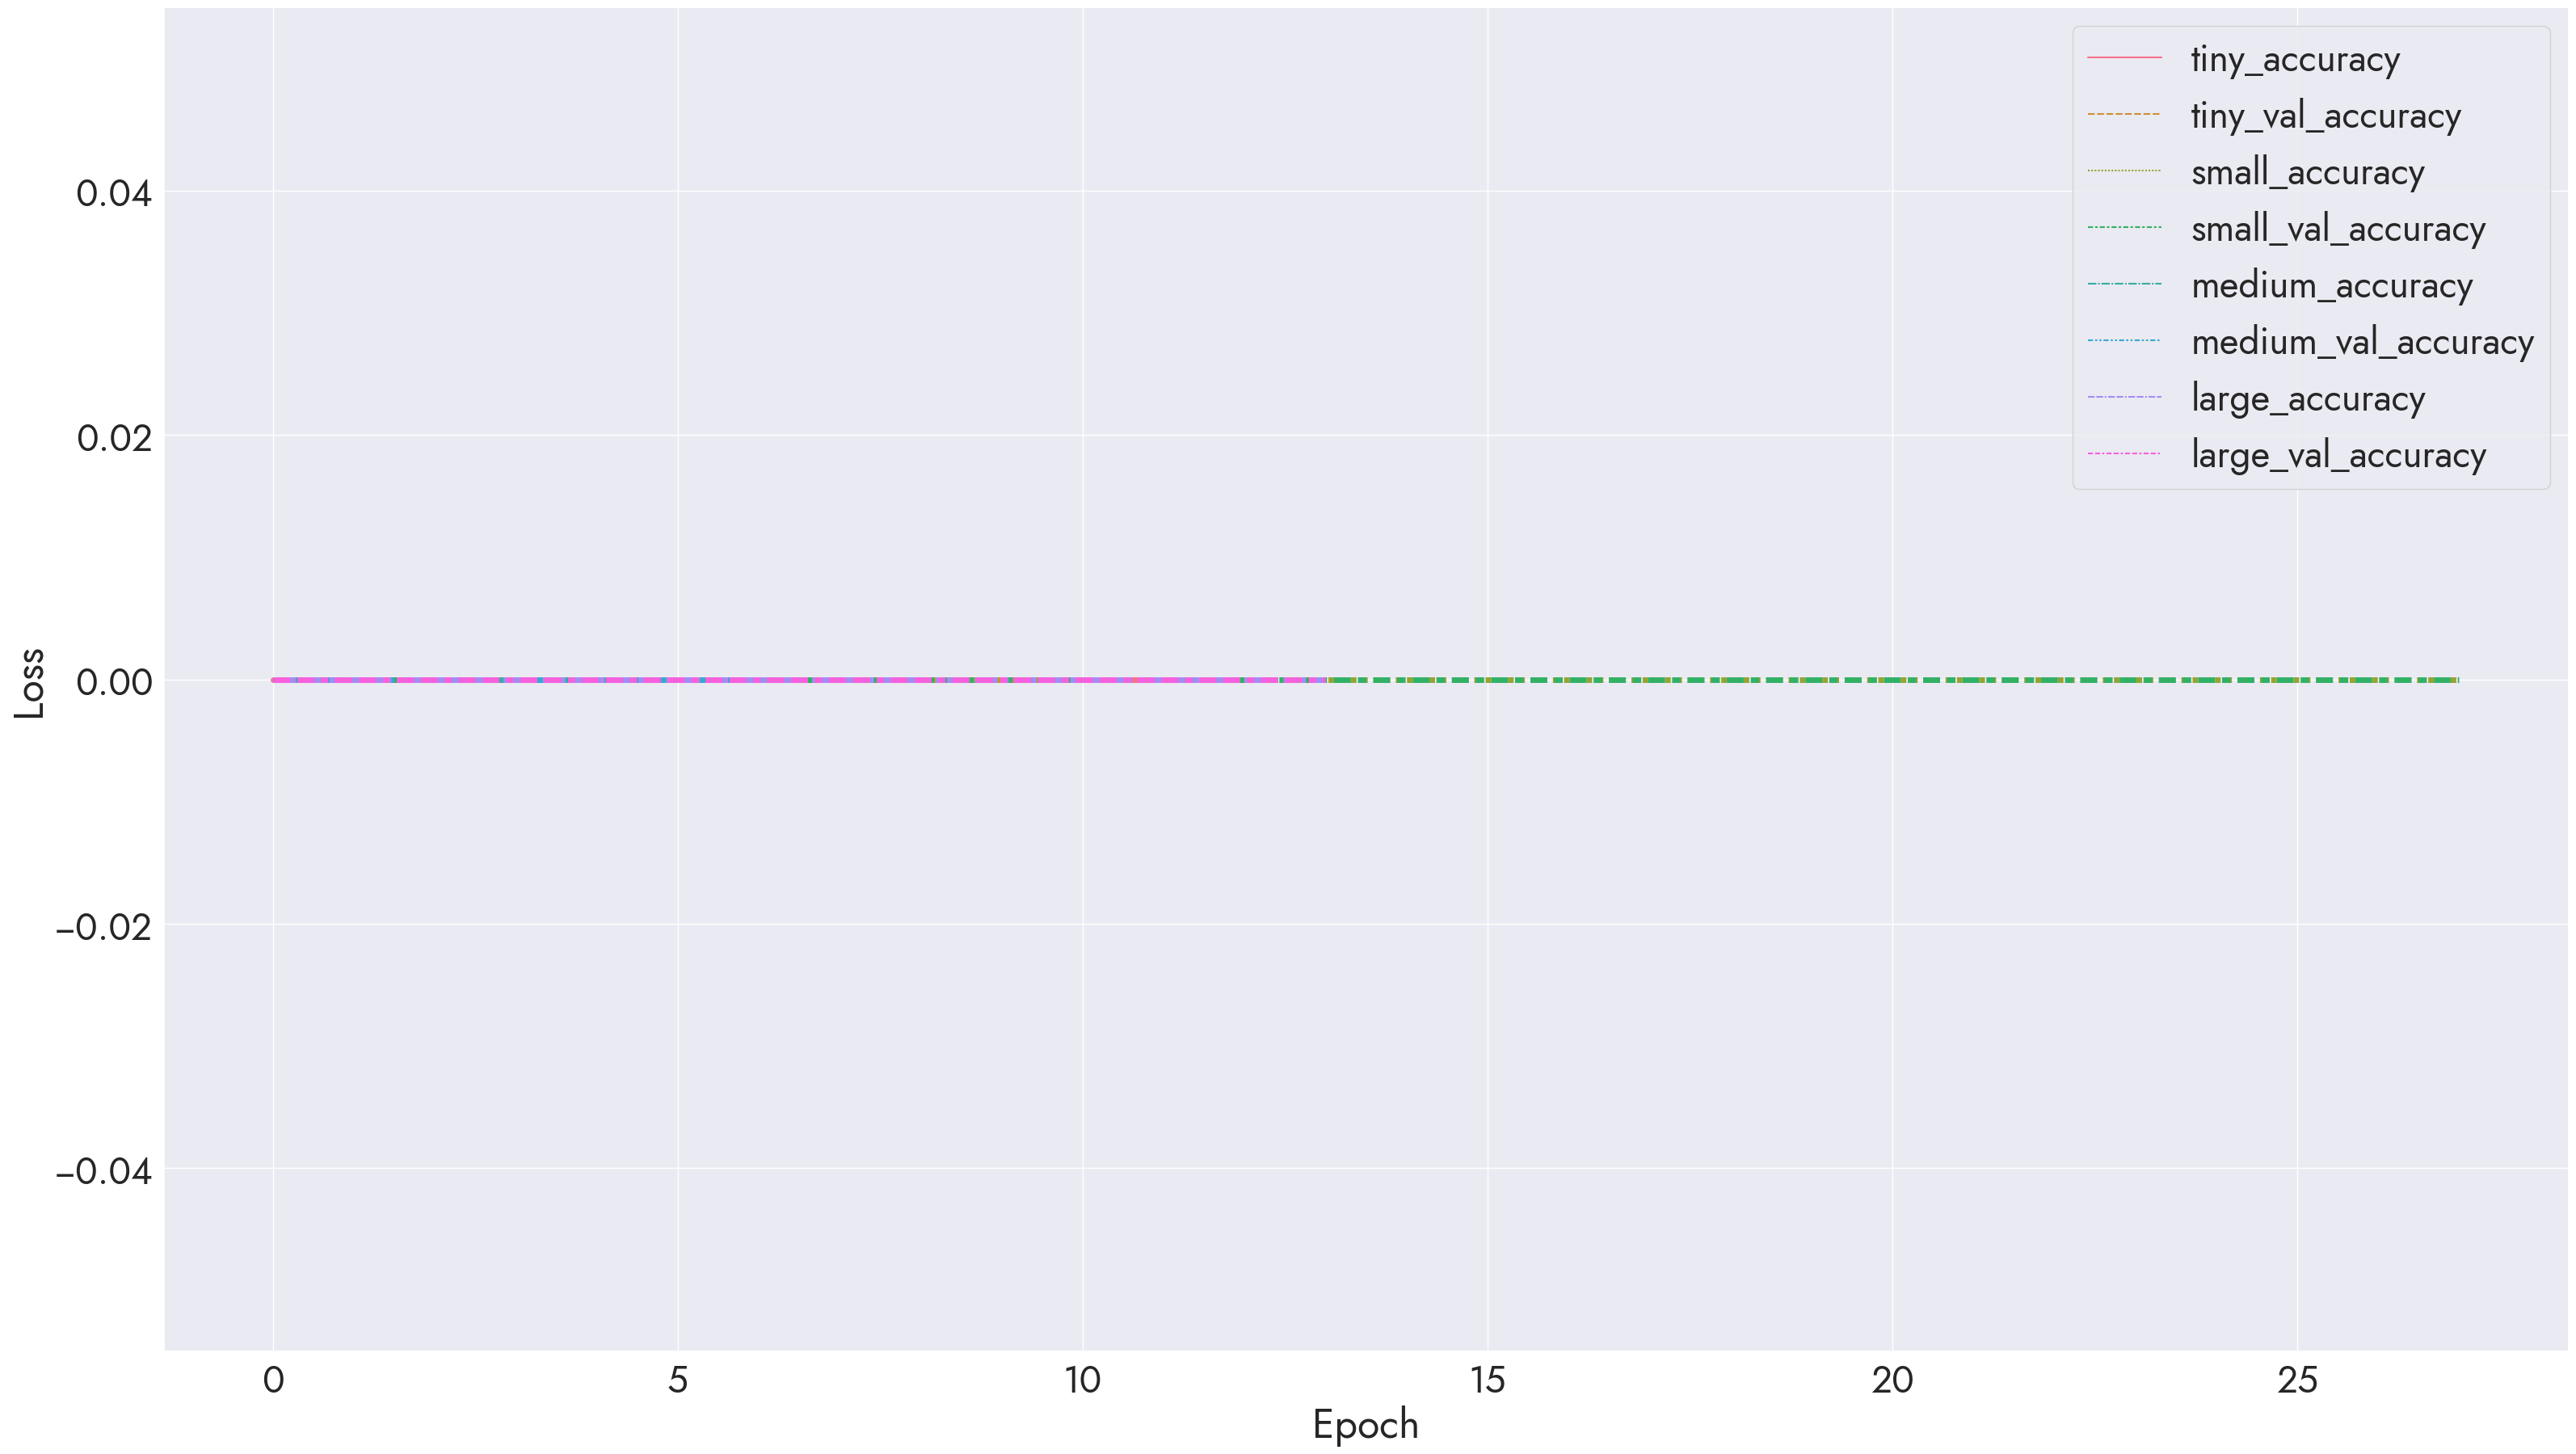

In [41]:
fixed_plot_history = sns.lineplot(
    data=pd.concat(
        [pd.DataFrame(history)[['accuracy', 'val_accuracy']].rename(columns={'accuracy': f'{size}_accuracy', 'val_accuracy': f'{size}_val_accuracy'})
         for size, history in size_histories.items()],
        axis="columns"
    ),
    linewidth=5)

fixed_plot_history.set_xlabel('Epoch')
fixed_plot_history.set_ylabel('Loss');

In [42]:
fixed_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_history.png', transparent=True)

Выберем в качестве основной модель с наименьшими ошибками

In [43]:
fixed_model = large_model

### Диаграммы
Визуализируем полученные результаты - начнём с определения предсказанных значений

In [44]:
test_predict = fixed_model.predict(test_features, verbose=2).flatten();

5/5 - 0s - 85ms/epoch - 17ms/step


Визуализируем потери предсказаний в модели

In [45]:
fixed_plot_relation = sns.regplot(x=test_target, y=test_predict)

fixed_plot_relation.set_xlabel('Target')
fixed_plot_relation.set_ylabel('Predict');

ValueError: regplot inputs must be 1d

In [ ]:
fixed_plot_relation.figure.savefig(f'{VISUAL_PATH}/fixed_relation.png', transparent=True)

Визуализируем распределение ошибок модели

In [ ]:
fixed_plot_mistakes = sns.histplot(data=test_predict - test_target)

fixed_plot_mistakes.set_xlabel('Value');

Большинство наблюдений было предсказано правильно. При этом, учитывая правостороннюю ассиметрию, модель стремится определить большие показатели наблюдениям, чем они есть на самом деле.

In [ ]:
fixed_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/fixed_mistakes.png', transparent=True)